# NDIndex Performance

This notebook benchmarks NDIndex performance for various operations and dataset sizes.
Understanding performance characteristics helps you make informed decisions about
when and how to use NDIndex in your workflows.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from linked_indices import NDIndex

## Benchmark Utilities

In [2]:
def benchmark(func, n_runs=100, warmup=5):
    """Benchmark a function and return timing statistics."""
    # Warmup runs
    for _ in range(warmup):
        func()

    # Timed runs
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        func()
        end = time.perf_counter()
        times.append(end - start)

    times = np.array(times)
    return {
        "mean": times.mean(),
        "std": times.std(),
        "min": times.min(),
        "max": times.max(),
        "median": np.median(times),
    }


def create_dataset(n_trials, n_times):
    """Create a test dataset with given dimensions."""
    trial_onsets = np.arange(n_trials) * n_times * 0.01
    rel_time = np.linspace(0, n_times * 0.01, n_times)

    abs_time = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]
    data = np.random.randn(n_trials, n_times)

    ds = xr.Dataset(
        {"data": (["trial", "rel_time"], data)},
        coords={
            "trial": np.arange(n_trials),
            "rel_time": rel_time,
            "abs_time": (["trial", "rel_time"], abs_time),
        },
    )
    return ds.set_xindex(["abs_time"], NDIndex)

## 1. Index Creation Performance

How long does it take to create an NDIndex for datasets of different sizes?

In [3]:
# Test different dataset sizes
sizes = [
    (10, 100),  # 1K cells
    (10, 1000),  # 10K cells
    (100, 1000),  # 100K cells
    (100, 10000),  # 1M cells
    (1000, 10000),  # 10M cells
]

creation_results = []
for n_trials, n_times in sizes:
    n_cells = n_trials * n_times

    # Create base dataset without index
    trial_onsets = np.arange(n_trials) * n_times * 0.01
    rel_time = np.linspace(0, n_times * 0.01, n_times)
    abs_time = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]
    data = np.random.randn(n_trials, n_times)

    ds_base = xr.Dataset(
        {"data": (["trial", "rel_time"], data)},
        coords={
            "trial": np.arange(n_trials),
            "rel_time": rel_time,
            "abs_time": (["trial", "rel_time"], abs_time),
        },
    )

    # Benchmark index creation
    result = benchmark(lambda: ds_base.set_xindex(["abs_time"], NDIndex), n_runs=50)
    result["n_cells"] = n_cells
    result["n_trials"] = n_trials
    result["n_times"] = n_times
    creation_results.append(result)

    print(
        f"{n_trials:4d} trials × {n_times:5d} times ({n_cells:>8,} cells): {result['mean'] * 1000:>8.3f} ms"
    )

  10 trials ×   100 times (   1,000 cells):    0.006 ms
  10 trials ×  1000 times (  10,000 cells):    0.006 ms
 100 trials ×  1000 times ( 100,000 cells):    0.006 ms
 100 trials × 10000 times (1,000,000 cells):    0.006 ms
1000 trials × 10000 times (10,000,000 cells):    0.006 ms


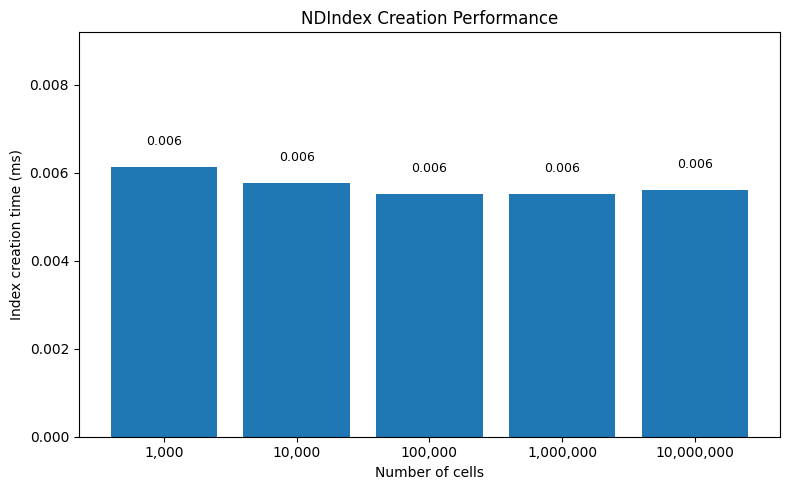

In [4]:
# Plot creation times
df = pd.DataFrame(creation_results)

fig, ax = plt.subplots(figsize=(8, 5))

# Use bar chart to show creation is essentially constant
x_labels = [f"{r['n_cells']:,}" for r in creation_results]
ax.bar(x_labels, df["mean"] * 1000)
ax.set_xlabel("Number of cells")
ax.set_ylabel("Index creation time (ms)")
ax.set_title("NDIndex Creation Performance")
ax.set_ylim(0, max(df["mean"] * 1000) * 1.5)  # Start at 0 to show how small these are

# Add text showing the actual values
for i, (x, y) in enumerate(zip(x_labels, df["mean"] * 1000)):
    ax.text(i, y + 0.0005, f"{y:.3f}", ha="center", fontsize=9)

plt.tight_layout()

**Key insight:** NDIndex creation is O(1) - it just stores a reference to the coordinate array.
No preprocessing or tree-building is required.

## 2. Scalar Selection Performance

How long does `sel(abs_time=value, method='nearest')` take?

In [5]:
scalar_results = []

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    ds = create_dataset(n_trials, n_times)

    # Pick a random target value in the middle of the range
    target = float(ds.abs_time.values.mean())

    # Benchmark scalar selection
    result = benchmark(lambda: ds.sel(abs_time=target, method="nearest"), n_runs=100)
    result["n_cells"] = n_cells
    scalar_results.append(result)

    print(
        f"{n_cells:>10,} cells: {result['mean'] * 1000:>8.3f} ms (±{result['std'] * 1000:.3f})"
    )

     1,000 cells:    0.056 ms (±0.017)
    10,000 cells:    0.071 ms (±0.018)
   100,000 cells:    0.259 ms (±0.173)


 1,000,000 cells:    3.969 ms (±7.272)


10,000,000 cells:   25.385 ms (±3.130)


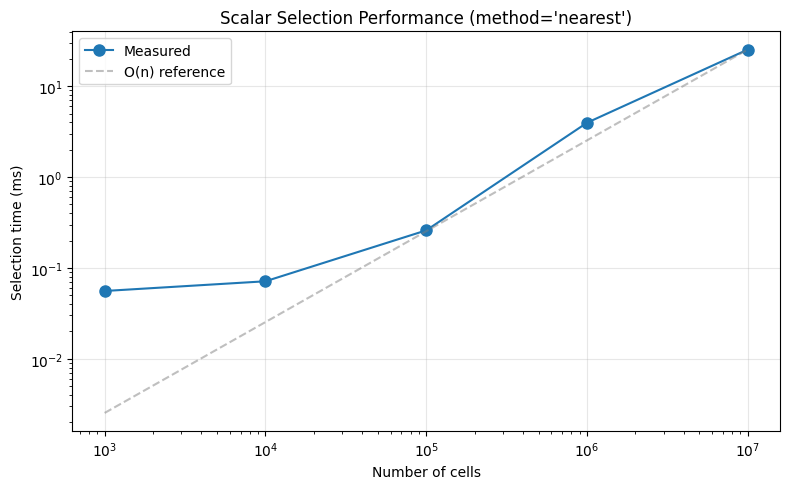

In [6]:
# Plot scalar selection times
df_scalar = pd.DataFrame(scalar_results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(
    df_scalar["n_cells"], df_scalar["mean"] * 1000, "o-", markersize=8, label="Measured"
)

# Add O(n) reference line (anchored to largest size to show theoretical worst case)
x_ref = np.array([df_scalar["n_cells"].min(), df_scalar["n_cells"].max()])
y_ref = df_scalar["mean"].iloc[-1] * 1000 * (x_ref / x_ref[-1])
ax.plot(x_ref, y_ref, "--", color="gray", alpha=0.5, label="O(n) reference")

ax.set_xlabel("Number of cells")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Scalar Selection Performance (method='nearest')")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()

**Key insights:**

1. **Fixed overhead dominates at small sizes** (~0.06ms for xarray machinery, index lookup, result construction)

2. **Scaling is O(n) for large arrays** - from 100K to 10M cells (100× increase), time increases ~100× as expected

3. **NumPy makes O(n) fast** - `np.argmin` uses SIMD vectorization and cache-efficient memory access, so even 10M cells only takes ~25ms

**Bottom line:** The algorithm is O(n), but numpy's optimizations make the constant factor very small. For typical neuroscience datasets (<1M cells), selection is effectively instant (~1-2ms).

## 3. Slice Selection Performance

How long does `sel(abs_time=slice(start, stop))` take?

In [7]:
slice_results = []

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    ds = create_dataset(n_trials, n_times)

    # Select middle 50% of the data
    vmin, vmax = ds.abs_time.values.min(), ds.abs_time.values.max()
    start = vmin + (vmax - vmin) * 0.25
    stop = vmin + (vmax - vmin) * 0.75

    # Benchmark slice selection
    result = benchmark(lambda: ds.sel(abs_time=slice(start, stop)), n_runs=100)
    result["n_cells"] = n_cells
    slice_results.append(result)

    print(
        f"{n_cells:>10,} cells: {result['mean'] * 1000:>8.3f} ms (±{result['std'] * 1000:.3f})"
    )

     1,000 cells:    0.084 ms (±0.142)
    10,000 cells:    0.062 ms (±0.004)
   100,000 cells:    0.135 ms (±0.008)
 1,000,000 cells:    0.904 ms (±0.080)


10,000,000 cells:    9.108 ms (±1.296)


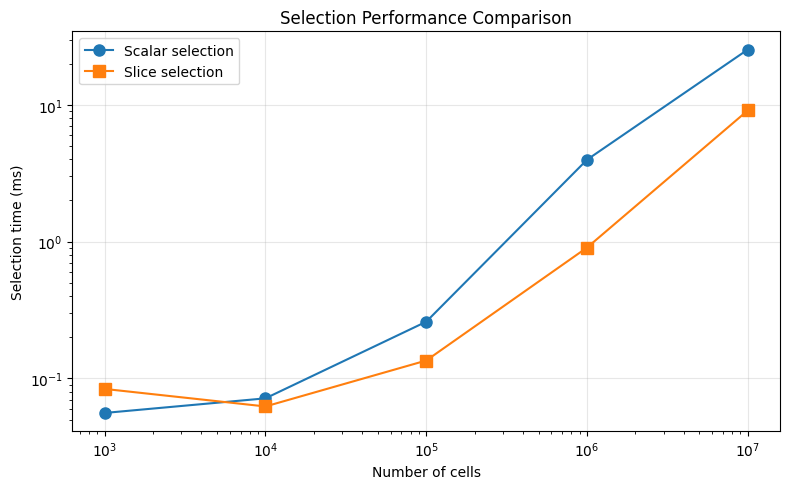

In [8]:
# Compare scalar vs slice selection
df_slice = pd.DataFrame(slice_results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(
    df_scalar["n_cells"],
    df_scalar["mean"] * 1000,
    "o-",
    markersize=8,
    label="Scalar selection",
)
ax.loglog(
    df_slice["n_cells"],
    df_slice["mean"] * 1000,
    "s-",
    markersize=8,
    label="Slice selection",
)

ax.set_xlabel("Number of cells")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Selection Performance Comparison")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()

## 4. isel Performance

How does NDIndex affect `isel()` performance? This matters because
`isel()` needs to slice the internal coordinate arrays.

In [9]:
isel_results = []

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    ds = create_dataset(n_trials, n_times)

    # Also create version without NDIndex for comparison
    ds_no_index = ds.drop_indexes("abs_time")

    # Benchmark isel with NDIndex
    result_with = benchmark(lambda: ds.isel(trial=0), n_runs=100)
    result_without = benchmark(lambda: ds_no_index.isel(trial=0), n_runs=100)

    isel_results.append(
        {
            "n_cells": n_cells,
            "with_index": result_with["mean"],
            "without_index": result_without["mean"],
            "overhead": result_with["mean"] / result_without["mean"],
        }
    )

    print(
        f"{n_cells:>10,} cells: with={result_with['mean'] * 1000:.3f}ms, without={result_without['mean'] * 1000:.3f}ms, overhead={result_with['mean'] / result_without['mean']:.2f}x"
    )

     1,000 cells: with=0.036ms, without=0.027ms, overhead=1.34x
    10,000 cells: with=0.031ms, without=0.024ms, overhead=1.29x
   100,000 cells: with=0.036ms, without=0.029ms, overhead=1.22x


 1,000,000 cells: with=0.031ms, without=0.025ms, overhead=1.27x


10,000,000 cells: with=0.036ms, without=0.024ms, overhead=1.48x


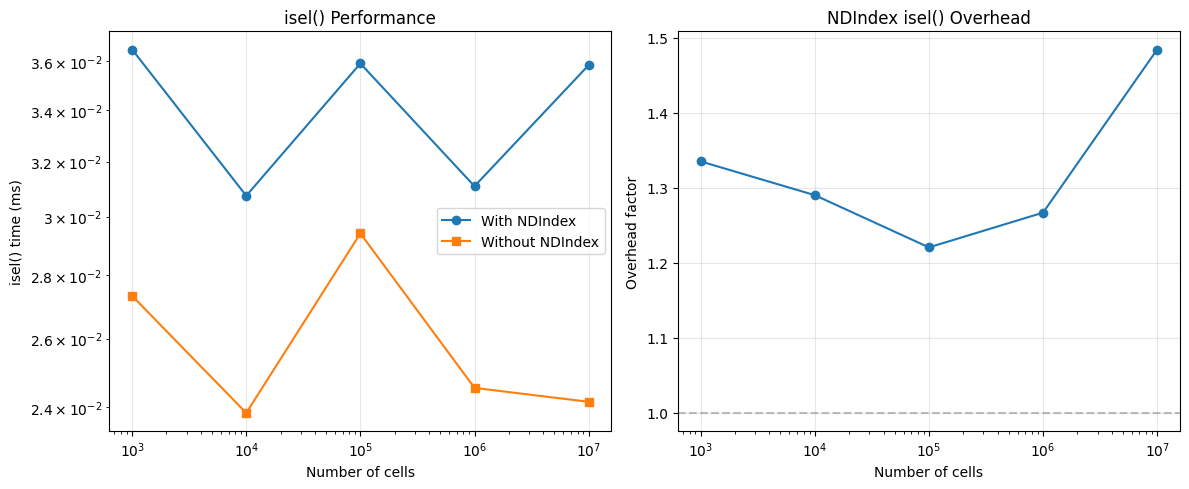

In [10]:
df_isel = pd.DataFrame(isel_results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.loglog(df_isel["n_cells"], df_isel["with_index"] * 1000, "o-", label="With NDIndex")
ax.loglog(
    df_isel["n_cells"], df_isel["without_index"] * 1000, "s-", label="Without NDIndex"
)
ax.set_xlabel("Number of cells")
ax.set_ylabel("isel() time (ms)")
ax.set_title("isel() Performance")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.semilogx(df_isel["n_cells"], df_isel["overhead"], "o-")
ax.axhline(1, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("Number of cells")
ax.set_ylabel("Overhead factor")
ax.set_title("NDIndex isel() Overhead")
ax.grid(True, alpha=0.3)

plt.tight_layout()

## 5. Memory Usage

NDIndex stores references to coordinate arrays, not copies.
Let's verify the memory overhead is minimal.

In [11]:
# Create a large dataset
n_trials, n_times = 100, 10000
n_cells = n_trials * n_times

trial_onsets = np.arange(n_trials) * n_times * 0.01
rel_time = np.linspace(0, n_times * 0.01, n_times)
abs_time = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]
data = np.random.randn(n_trials, n_times)

ds_base = xr.Dataset(
    {"data": (["trial", "rel_time"], data)},
    coords={
        "trial": np.arange(n_trials),
        "rel_time": rel_time,
        "abs_time": (["trial", "rel_time"], abs_time),
    },
)

ds_indexed = ds_base.set_xindex(["abs_time"], NDIndex)

# Check if the arrays share memory
print(f"Dataset size: {n_cells:,} cells")
print(f"abs_time array size: {abs_time.nbytes / 1024 / 1024:.2f} MB")
print(
    f"Arrays share memory: {np.shares_memory(ds_base.abs_time.values, ds_indexed.abs_time.values)}"
)

Dataset size: 1,000,000 cells
abs_time array size: 7.63 MB
Arrays share memory: True


## 6. Comparison: Multiple Coordinates

How does performance scale when indexing multiple N-D coordinates?

In [12]:
# Create dataset with multiple 2D coordinates
n_trials, n_times = 100, 1000
n_cells = n_trials * n_times

trial_onsets = np.arange(n_trials) * 10.0
rel_time = np.linspace(0, 5.0, n_times)
abs_time = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]

# Create event-locked coordinates
event1_times = np.random.uniform(1, 2, n_trials)
event2_times = np.random.uniform(2, 3, n_trials)
event1_locked = rel_time[np.newaxis, :] - event1_times[:, np.newaxis]
event2_locked = rel_time[np.newaxis, :] - event2_times[:, np.newaxis]

ds_multi = xr.Dataset(
    {"data": (["trial", "rel_time"], np.random.randn(n_trials, n_times))},
    coords={
        "trial": np.arange(n_trials),
        "rel_time": rel_time,
        "abs_time": (["trial", "rel_time"], abs_time),
        "event1_locked": (["trial", "rel_time"], event1_locked),
        "event2_locked": (["trial", "rel_time"], event2_locked),
    },
)

print("Benchmarking with 1, 2, and 3 indexed coordinates...")
print()

# Index different numbers of coordinates
for n_coords, coords in [
    (1, ["abs_time"]),
    (2, ["abs_time", "event1_locked"]),
    (3, ["abs_time", "event1_locked", "event2_locked"]),
]:
    ds_test = ds_multi.set_xindex(coords, NDIndex)

    # Benchmark selection on first coordinate
    target = float(ds_test.abs_time.values.mean())
    result = benchmark(
        lambda: ds_test.sel(abs_time=target, method="nearest"), n_runs=100
    )

    print(f"{n_coords} coord(s): sel() = {result['mean'] * 1000:.3f} ms")

Benchmarking with 1, 2, and 3 indexed coordinates...

1 coord(s): sel() = 0.189 ms
2 coord(s): sel() = 0.170 ms
3 coord(s): sel() = 0.167 ms


## Summary

### Performance Characteristics

| Operation | Complexity | Notes |
|-----------|------------|-------|
| Index creation | O(1) | Just stores reference, no preprocessing |
| Scalar selection (nearest) | O(n) | Linear scan with `np.argmin` |
| Scalar selection (exact) | O(n) | Linear scan with `np.where` |
| Slice selection | O(n) | Boolean masking + bounding box computation |
| `isel()` | O(1) | Array slicing is fast |

### Recommendations

1. **Small-medium datasets (<1M cells)**: NDIndex adds negligible overhead
2. **Large datasets (1-10M cells)**: Selection takes ~10-100ms, usually acceptable
3. **Very large datasets (>10M cells)**: Consider:
   - Pre-filtering with `isel()` before `sel()`
   - Using exact matching instead of nearest-neighbor
   - Chunking your data with dask

4. **Memory**: NDIndex doesn't copy data, so memory overhead is minimal